In [1]:
import numpy as np
import pylab as plt
import scipy.optimize
import scipy.interpolate

# Ensure this is at the very top of your notebook
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Disable problematic Metal plugin
tf.keras.utils.disable_interactive_logging() # turn off annoying progress indicator

In [2]:
import VeryAccurateEmulator as VAE
emulator = VAE.emulator.DirectEmulator()
emulator.load_model()  # load pretrained emulator. Use the model_path kwarg to load other models.
# Add after model loading
emulator.emulator.compile(
    optimizer='adam',  # Match your original optimizer
    loss='mse',        # Match your original loss function
    metrics=['mae']    # Add your original metrics
)
emulator.emulator.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/21cmvae/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [3]:
params = emulator.par_labels
params

['fstar', 'Vc', 'fx', 'tau', 'alpha', 'nu_min', 'Rmfp']

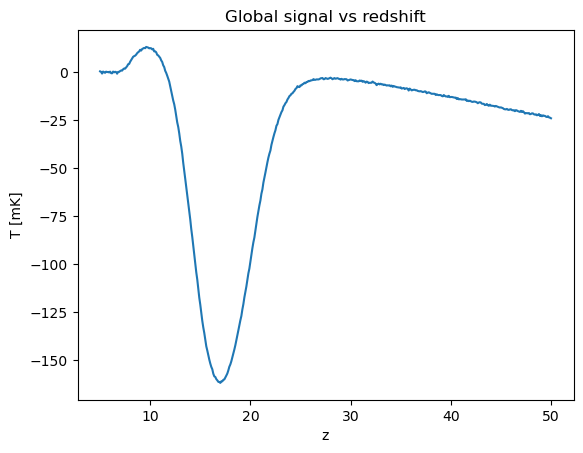

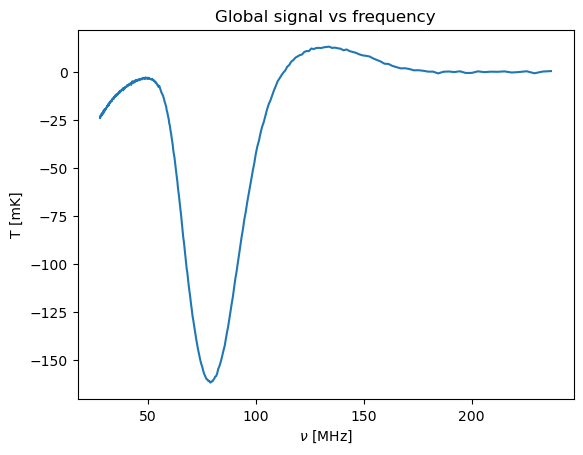

In [4]:


#p0 = [0.0003, 4.2, 0, 0.055, 1.0, 0.1, 10]  # in the order given in the above cell
p0 = [10.**-0.8, 10.**1.4803, 10.**-0.1190, 0.07, 1.25, 0.85, 29.6]  # in the order given in the above cell

# alternatively, params can be a (N, 7)-numpy array, where N is the number of different cases you want to emulate at once.
# In that case, the output is a (N, 451)-numpy array. 
# For example, if you have a csv file with 500 cases organized in a 500x7-table, just do 
# params = np.loadtxt(<filepath>)

global_signal = emulator.predict(p0)  # emulate the global signal

import matplotlib.pyplot as plt
redshifts = emulator.redshifts  # an array of length 451 with redshifts 5-50:0.1
plt.figure()
plt.plot(redshifts, global_signal)
plt.title('Global signal vs redshift')
plt.xlabel('z')
plt.ylabel('T [mK]')
plt.show()

frequencies = emulator.frequencies  # an array of length 451 with equivalent frequencies
plt.figure()
plt.plot(frequencies, global_signal)
plt.title('Global signal vs frequency')
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel('T [mK]')
plt.show()

(80, 7)


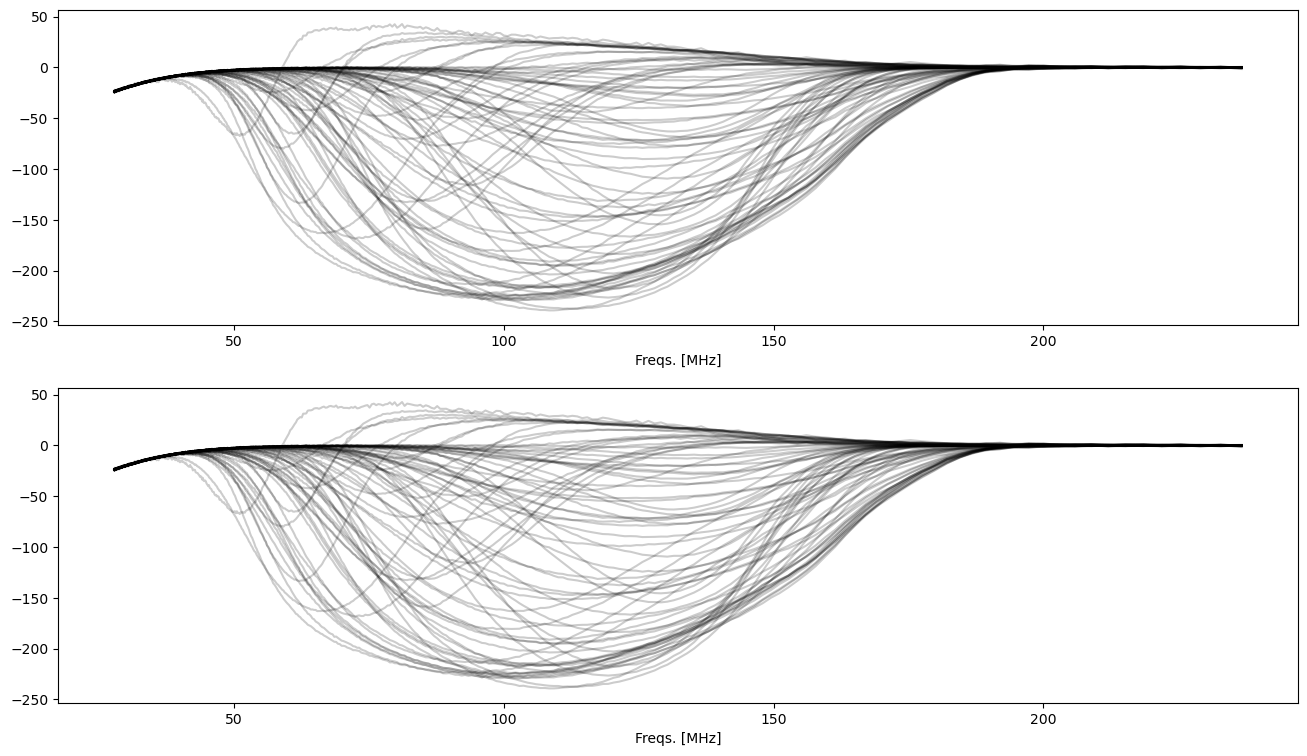

In [5]:
# Parameters to vary
Nmodels = 80
ranges = {
    'fstar':    (1e-4, 0.5),
    'Vc':       (4.2, 100.),
    'fx':       (1e-5, 1000.),
    'nu_min':   (0.1, 3.0)
}

# Randomly sample free parameters (keep others fixed)
vals = []
for i, param in enumerate(params):
    pp = p0[i] * np.ones(Nmodels)
    if param in ranges.keys():
        if param == 'nu_min':
            pp = np.random.uniform(low=ranges[param][0], 
                                   high=ranges[param][1], 
                                   size=Nmodels)
        else:
            pp = 10.**np.random.uniform(low=np.log10(ranges[param][0]), 
                                        high=np.log10(ranges[param][1]), 
                                        size=Nmodels)
            
    vals.append(pp)
vals = np.array(vals).T
print(vals.shape)

gs = emulator.predict(vals)

plt.subplot(211)
plt.plot(frequencies, gs.T, color='k', alpha=0.2)
plt.xlabel("Freqs. [MHz]")

plt.subplot(212)
plt.plot(frequencies, gs.T, color='k', alpha=0.2)
plt.xlabel("Freqs. [MHz]")

plt.gcf().set_size_inches((16., 9.))

(80, 7)


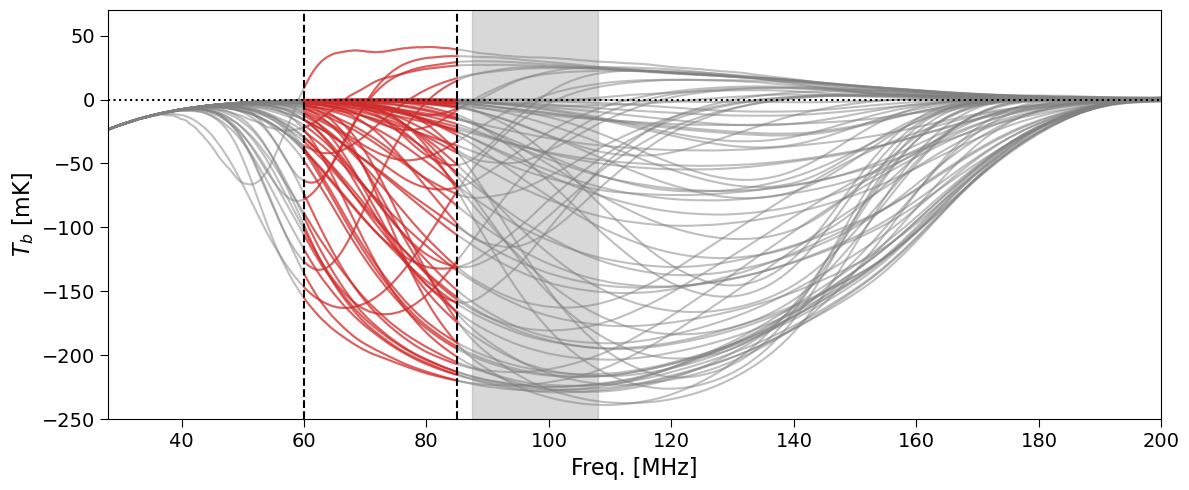

In [6]:
from scipy.signal import savgol_filter

freqs = np.linspace(60., 85., 280) # MHz
for i in range(gs.shape[0]):

    # Smooth the global signal
    smooth_gs = savgol_filter(gs[i], window_length=16, polyorder=3)
    
    # Interpolate onto our frequency channels
    interp = scipy.interpolate.interp1d(frequencies, smooth_gs, kind='cubic')
    gs_interp = interp(freqs)
    
    # Plot full 21cm emulator prediction, and interpolated values within our band
    y = vals[i,1] - np.min(vals[:,1])
    y /= np.max(np.log10(vals[:,1])) - np.min(np.log10(vals[:,1]))
    col = plt.cm.Spectral(y)
    #print(y)
    plt.plot(frequencies, smooth_gs, color='grey', alpha=0.5)
    plt.plot(freqs, gs_interp, color='r', alpha=0.5)

    #if i == 24:
    #    plt.plot(freqs, gs_interp, color='c', lw=4.)

    # Apply FG filter to interpolated theory function
    #_coeffs = gs_interp @ fg_operator
    #fg_part = (_coeffs @ fg_operator.T).real
    #plt.plot(freqs, fg_part, 'b--', alpha=0.7)
    #plt.plot(freqs, gs_interp - fg_part, 'g-', alpha=0.7)
print(vals.shape)
plt.xlim((28., 200.))
#plt.xlim((50., 90.))
plt.ylim((-250., 70.))

plt.axvline(60., ls='dashed', color='k')
plt.axvline(85., ls='dashed', color='k')
plt.axhline(0., ls='dotted', color='k')

plt.fill_betweenx(np.array([-350., 150.]), 87.5, 108., color='grey', alpha=0.3)

plt.xlabel("Freq. [MHz]", fontsize=16)
plt.ylabel("$T_b$ [mK]", fontsize=16)
plt.tick_params(which='both', size=6., labelsize=14)
plt.gcf().set_size_inches((12., 5.))
#plt.gcf().set_size_inches((5., 5.))
plt.tight_layout()
plt.savefig("tb_theory.pdf")

## Construct the covariance matrix of global 21cm signal

In [7]:
from scipy.interpolate import interp1d

target_freqs=np.arange(55.0, 85.0+0.5, 0.5)

gs_interpolated = np.zeros((len(gs),len(target_freqs)))
for i in range(len(gs)):
    data = gs[i]
    gs_interpolated[i, :] = interp1d(frequencies, data, kind='cubic', fill_value='extrapolate')(target_freqs)

In [8]:
cov_gs = gs_interpolated.T @ gs_interpolated
# PCA of the cov_gs matrix:

Just to see the PCA of the signal covariance matrix

In [9]:
# Ensure matrix is symmetric (should already be for covariance matrix)
assert np.allclose(cov_gs, cov_gs.T)

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_gs)

# Reverse order to get descending eigenvalues
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[:, ::-1].T

reconst_cov = 0
for i in range(len(eigenvalues)):
    # Ensure proper orientation: use eigenvector as column vector
    vec = eigenvectors[i].reshape(-1, 1) if eigenvectors.shape[0] == len(eigenvalues) else eigenvectors[:, i].reshape(-1, 1)
    reconst_cov += eigenvalues[i] * vec @ vec.T

np.allclose(cov_gs, reconst_cov, atol=1e-8)  # Adjust tolerance if needed


True

## Signal in the null space of foreground basis

In [10]:
from SEDfitting import *

In [11]:
mom_obj = moment_basis(target_freqs)

In [12]:
eta_adapted=[]
eta_fixed=[]
orders_li = np.arange(1, 12, 1)
for n in orders_li:
    eta_adapted.append(mom_obj.null_space_covariance(-2.9, n, cov_gs, remove_1st_moment=True))
    eta_fixed.append(mom_obj.null_space_covariance(-2.9, n, cov_gs, remove_1st_moment=False))

In [14]:
## Signal in the null space of the modulated foreground basis

In [18]:
from fg_model import *
freq_list = np.arange(55.0, 85.0+0.5, 0.5)

# Load the RHINO wet soil beam
horn_wet = RhinoBeam(filepath='/Users/zzhang/Downloads/HornWet/')
horn_wet.get_beam_l()
beam_window = horn_wet.bl_list

# Generate the beam convolved Mel maps
Mel_model = SynchrotronExtrapolator()
mel_sky_RHINO_convolved = Mel_model.map(freq_list, beam_window)

ref_beam_window = horn_wet.bl_list[30]
ref_map = Mel_model.map(freq_list[30])
BCF_cube = np.array(horn_wet.generate_BCF(ref_map, ref_beam_window))

In [19]:
eta_BCF_adapted=[]
orders_li = np.arange(1, 12, 1)
for n in orders_li:
    eta_BCF_adapted.append(mom_obj.null_space_covariance(-2.9, n, cov_gs, remove_1st_moment=True, BCF=BCF_cube[1691211, :]))

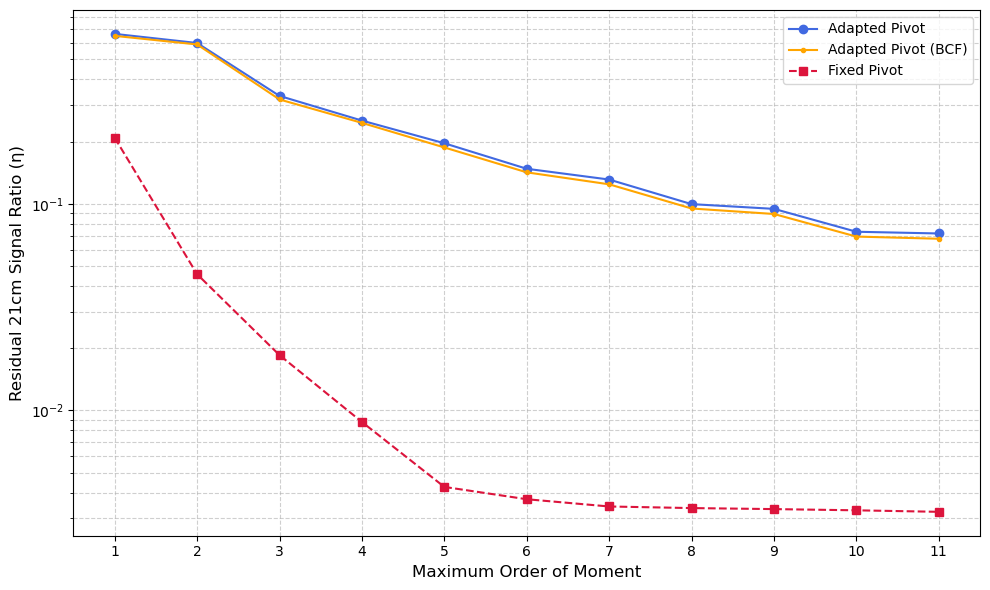

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Visualization
plt.figure(figsize=(10, 6))
plt.semilogy(orders_li, eta_adapted, 'o-', label='Adapted Pivot', color='royalblue')
plt.semilogy(orders_li, eta_BCF_adapted, '.-', label='Adapted Pivot (BCF)', color='orange')
plt.semilogy(orders_li, eta_fixed, 's--', label='Fixed Pivot', color='crimson')

plt.xlabel('Maximum Order of Moment', fontsize=12)
plt.ylabel('Residual 21cm Signal Ratio (η)', fontsize=12)
#plt.title('Foreground Subtraction Efficiency', fontsize=14)
plt.xticks(orders_li)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('eta_vs_orders.pdf', dpi=300)

# Add data table below plot
# df = pd.DataFrame({
#     'Moments': orders_li,
#     'η_adapted': eta_adapted,
#     'η_fixed': eta_fixed
# }).set_index('Moments')

# display(df)